# Support Vector Machine 구현하기

이 노트북에서는 Support Vector Machine(SVM)의 기본 개념을 이해하고 간단한 버전을 직접 구현해보겠습니다.

## 목차
1. 기본 개념 이해하기
2. 데이터 준비
3. 간단한 선형 SVM 구현
4. 결과 시각화
5. 개선 방향 논의

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 기본 개념 이해하기

SVM의 주요 개념:
- 결정 경계(Decision Boundary): 두 클래스를 구분하는 선/면
- 마진(Margin): 결정 경계와 가장 가까운 데이터 포인트 사이의 거리
- 서포트 벡터(Support Vectors): 마진을 결정하는 데이터 포인트들

우리는 가장 기본적인 선형 SVM부터 구현해보겠습니다.

## 2. 데이터 준비

간단한 2차원 데이터를 생성하여 시작해보겠습니다.

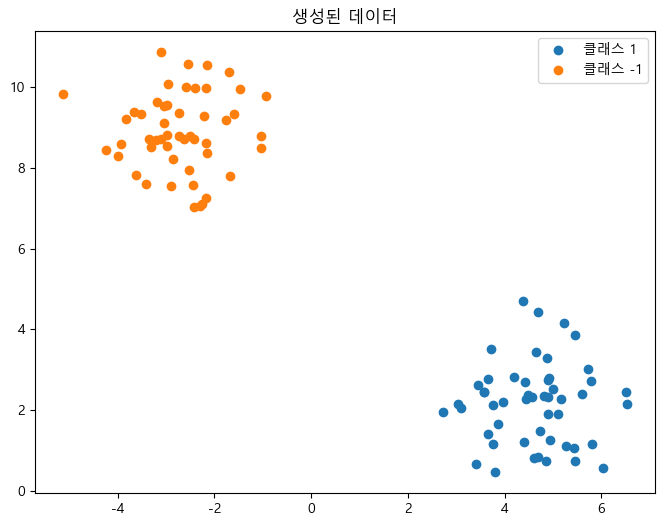

In [2]:
def generate_data(n_samples=100):
    """간단한 이진 분류 데이터셋 생성"""
    X, y = make_blobs(n_samples=n_samples, centers=2, random_state=42)
    # 레이블을 1과 -1로 변환 (SVM 규칙)
    y = np.where(y == 0, -1, 1)
    return X, y

# 데이터 생성
X, y = generate_data()

# 데이터 시각화
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='클래스 1')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='클래스 -1')
plt.title('생성된 데이터')
plt.legend()
plt.show()

In [7]:
# 결정 경계 시각화 함수
def plot_decision_boundary(X, y, model):
    plt.figure(figsize=(10, 8))
    
    # 데이터 포인트 그리기
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='클래스 1')
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='클래스 -1')
    
    # 결정 경계 그리기
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])
    
    plt.title('SVM 결정 경계')
    plt.legend()
    plt.show()

## 3. 간단한 선형 SVM 구현 with Primal SVM + Hinge Loss + L2
- SVM은 $\frac{1}{2}\|\mathbf{w}\|^2 + C \sum \max(0, 1 - y_i(\mathbf{w}^\top \mathbf{x}_i + b))$를 최소화한다.
- $y_i(\mathbf{w}^\top \mathbf{x}_i + b) \geq 1$이면 $\nabla_{\mathbf{w}} = \lambda \mathbf{w}$, 그렇지 않으면 $\nabla_{\mathbf{w}} = \lambda \mathbf{w} - y_i \mathbf{x}_i$이다.
- 경사하강법으로 $\mathbf{w}, b$를 반복 업데이트하여 최대 마진 분류기를 학습한다.


In [8]:
class SimpleSVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param  # = 1 / C
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)  # ensure y in {-1, 1}

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) + self.b)

                if condition >= 1:
                    dw = self.lambda_param * self.w
                    db = 0
                else:
                    dw = self.lambda_param * self.w - y_[idx] * x_i
                    db = -y_[idx]

                self.w -= self.lr * dw
                self.b -= self.lr * db

    def predict(self, X):
        linear_output = np.dot(X, self.w) + self.b
        return np.sign(linear_output)

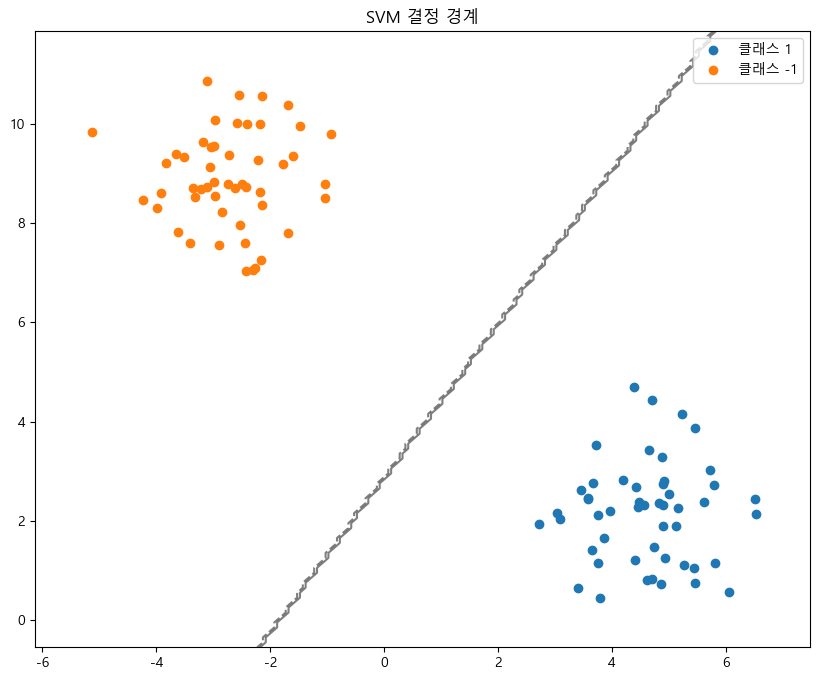

In [9]:
# 모델 학습
svm = SimpleSVM()
svm.fit(X, y)

# 결과 시각화
plot_decision_boundary(X, y, svm)

## 3-1. 간단한 선형 SVM 구현 with GD

기본적인 선형 SVM은 다음과 같은 결정 함수를 사용합니다:

f(x) = wx + b

여기서:
- w: 가중치 벡터
- x: 입력 데이터
- b: 편향

우리는 간단한 경사 하강법을 사용하여 이 파라미터들을 학습할 것입니다.

In [10]:
class SimpleSVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # 가중치와 편향 초기화
        self.w = np.zeros(n_features)
        self.b = 0
        
        # 경사 하강법
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y[idx]))
                    self.b -= self.lr * y[idx]
    
    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

## 4. 모델 학습 및 결과 시각화

이제 구현한 SVM 모델을 학습하고 결과를 시각화해보겠습니다.

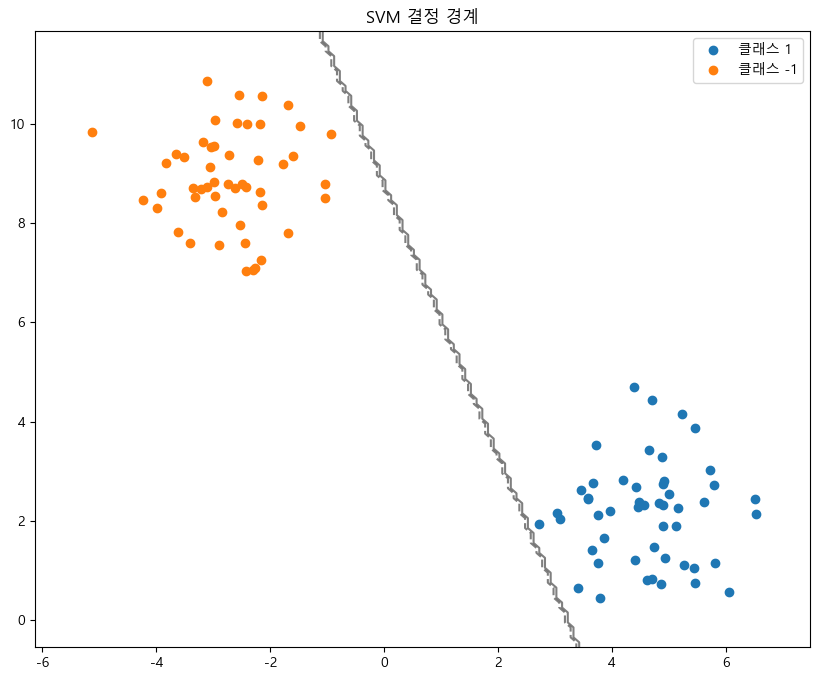

In [11]:
# 모델 학습
svm = SimpleSVM()
svm.fit(X, y)

# 결과 시각화
plot_decision_boundary(X, y, svm)

## 5. 개선 방향

지금까지 구현한 SVM은 매우 기본적인 버전입니다. 다음과 같은 방향으로 개선할 수 있습니다:

1. 커널 트릭 추가하기 (비선형 분류)
2. SMO(Sequential Minimal Optimization) 알고리즘 적용
3. 소프트 마진 구현
4. 다중 클래스 분류 지원

이러한 개선사항들은 차근차근 학습하면서 구현해볼 수 있습니다.